In [4]:
from datasets import load_dataset
import pandas as pd
from random import shuffle

#load huggingface dataset
dataset = load_dataset("conll2012_ontonotesv5", "english_v12", trust_remote_code=True)
train_data = dataset["train"]

#extract sentences
all_sentences = []
for doc in train_data:
    all_sentences.extend(doc["sentences"])

#take 1000 random samples
shuffle(all_sentences)
sampled_sentences = all_sentences[:1000]

#extract BIO label
label_names = dataset["train"].features["sentences"][0]["named_entities"].feature.names

#to token-level df
rows = []
for sent_id, sentence in enumerate(sampled_sentences):
    tokens = sentence["words"]
    label_ids = sentence["named_entities"]
    for token_id, (token, label_id) in enumerate(zip(tokens, label_ids)):
        rows.append({
            "sentence_id": sent_id,
            "token_id": token_id,
            "token": token,
            "BIO_NER_tag": label_names[label_id]
        })

train_df = pd.DataFrame(rows)
train_df = train_df.dropna().query("token != '' and BIO_NER_tag != ''")
train_df.to_csv("ontonotes_train_1000_token_level.csv", index=False)

In [21]:
#spacy
import pandas as pd
from spacy import load
from spacy.tokens import Doc
from sklearn.metrics import classification_report
from collections import Counter

#load test set
df_test = pd.read_csv("NER-test.tsv", sep="\t")
grouped = df_test.groupby("sentence_id")
sentences = grouped["token"].apply(list).tolist()
ground_truth = grouped["BIO_NER_tag"].apply(list).tolist()

#load spacy model
nlp = load("en_core_web_sm")

#predict
spacy_preds = []
for tokens in sentences:
    doc = Doc(nlp.vocab, words=tokens)
    doc = nlp(doc)
    tags = []
    for token in doc:
        if token.ent_iob_ == "B":
            tags.append("B-" + token.ent_type_)
        elif token.ent_iob_ == "I":
            tags.append("I-" + token.ent_type_)
        else:
            tags.append("O")
    spacy_preds.append(tags)

#flatten predictions and ground truth
flat_truth = [label for sentence in ground_truth for label in sentence]
flat_preds = [label for sentence in spacy_preds for label in sentence]

#print output that only labels in test set
test_labels = sorted(set(flat_truth))
print("spacy predicted tag distribution:", Counter(flat_preds))
print("\n spacy classification:")
print(classification_report(flat_truth, flat_preds, labels=test_labels, target_names=test_labels))

spacy predicted tag distribution: Counter({'O': 183, 'B-PERSON': 9, 'I-PERSON': 9, 'I-WORK_OF_ART': 8, 'B-ORG': 6, 'B-GPE': 5, 'B-DATE': 4, 'I-DATE': 4, 'I-FAC': 3, 'B-FAC': 2, 'B-WORK_OF_ART': 2, 'B-NORP': 1, 'I-ORG': 1})

 spacy classification:
               precision    recall  f1-score   support

        B-LOC       0.00      0.00      0.00         7
        B-ORG       0.00      0.00      0.00         3
     B-PERSON       0.78      0.64      0.70        11
B-WORK_OF_ART       1.00      0.22      0.36         9
        I-LOC       0.00      0.00      0.00         1
        I-ORG       0.00      0.00      0.00         2
     I-PERSON       0.67      0.75      0.71         8
I-WORK_OF_ART       0.50      0.40      0.44        10
            O       0.93      0.92      0.93       186

    micro avg       0.87      0.80      0.84       237
    macro avg       0.43      0.33      0.35       237
 weighted avg       0.85      0.80      0.82       237



C:\Users\ruuig\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ruuig\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ruuig\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
#tune BERT
import ast
from collections import Counter
from sklearn.model_selection import train_test_split
from simpletransformers.ner import NERModel, NERArgs

#load cleaned data
df = pd.read_csv("ontonotes_train_1000_token_level.csv")

#compute label with weights
label_counts = Counter(df["BIO_NER_tag"])
labels_list = sorted(label_counts.keys())
total = sum(label_counts.values())
weights = [total / label_counts[label] for label in labels_list]
norm_factor = sum(weights)
normalized_weights = [w / norm_factor for w in weights]

#split train-validation
sentence_ids = df["sentence_id"].drop_duplicates()
train_ids, eval_ids = train_test_split(sentence_ids, test_size=0.2, random_state=42)

train_df = df[df["sentence_id"].isin(train_ids)].reset_index(drop=True)
eval_df = df[df["sentence_id"].isin(eval_ids)].reset_index(drop=True)

#consistent name
train_df = train_df.rename(columns={"token": "words", "BIO_NER_tag": "labels"})
eval_df = eval_df.rename(columns={"token": "words", "BIO_NER_tag": "labels"})

#configure model
model_args = NERArgs()
model_args.num_train_epochs = 5
model_args.train_batch_size = 16
model_args.eval_batch_size = 16
model_args.evaluate_during_training = True
model_args.evaluate_during_training_steps = 30
model_args.use_multiprocessing = False
model_args.overwrite_output_dir = True
model_args.save_model_every_epoch = False
model_args.output_dir = "outputs/model/"
model_args.best_model_dir = "outputs/model/best_model"
model_args.metric_for_best_model = "f1"
model_args.greater_is_better = True
model_args.labels_list = labels_list
model_args.class_weights = normalized_weights
model_args.silent = True
model_args.logging_steps = 0

#train and save
model = NERModel("bert", "bert-base-cased", args=model_args, use_cuda=False)
model.train_model(train_df, eval_data=eval_df)
model.save_model("outputs/model_final/")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ruuig\anaconda3\envs\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
#bert evaluation
from sklearn.metrics import classification_report
from collections import Counter

#flatten
flat_truth = [label for sentence in ground_truth for label in sentence]
flat_preds = [list(item.values())[0] for sent in predictions for item in sent]

#print output that only labels in test set
test_labels = sorted(set(flat_truth))
print("BERT predicted tag distribution:", Counter(flat_preds))
print("\n BERT classification: ")
print(classification_report(
    flat_truth, 
    flat_preds, 
    labels=test_labels, 
    target_names=test_labels
))

BERT predicted tag distribution: Counter({'O': 189, 'B-PERSON': 15, 'B-GPE': 10, 'B-ORG': 6, 'B-DATE': 5, 'I-PERSON': 5, 'I-DATE': 3, 'I-GPE': 2, 'I-ORG': 1, 'B-NORP': 1})

 BERT classification: 
               precision    recall  f1-score   support

        B-LOC       0.00      0.00      0.00         7
        B-ORG       0.33      0.67      0.44         3
     B-PERSON       0.60      0.82      0.69        11
B-WORK_OF_ART       0.00      0.00      0.00         9
        I-LOC       0.00      0.00      0.00         1
        I-ORG       1.00      0.50      0.67         2
     I-PERSON       1.00      0.62      0.77         8
I-WORK_OF_ART       0.00      0.00      0.00        10
            O       0.94      0.95      0.94       186

    micro avg       0.90      0.82      0.86       237
    macro avg       0.43      0.40      0.39       237
 weighted avg       0.81      0.82      0.81       237



C:\Users\ruuig\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ruuig\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ruuig\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


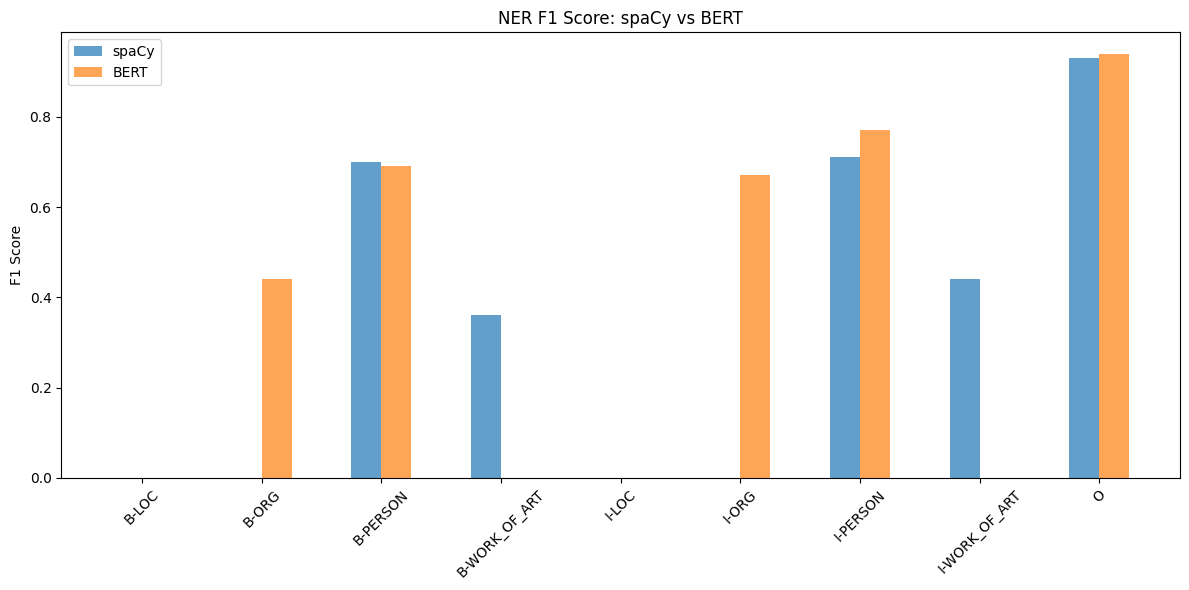

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

labels = ['B-LOC', 'B-ORG', 'B-PERSON', 'B-WORK_OF_ART', 'I-LOC', 'I-ORG', 'I-PERSON', 'I-WORK_OF_ART', 'O']

# spaCy
spacy_metrics = {
    'precision': [0.00, 0.00, 0.78, 1.00, 0.00, 0.00, 0.67, 0.50, 0.93],
    'recall':    [0.00, 0.00, 0.64, 0.22, 0.00, 0.00, 0.75, 0.40, 0.92],
    'f1-score':  [0.00, 0.00, 0.70, 0.36, 0.00, 0.00, 0.71, 0.44, 0.93]
}

# BERT
bert_metrics = {
    'precision': [0.00, 0.33, 0.60, 0.00, 0.00, 1.00, 1.00, 0.00, 0.94],
    'recall':    [0.00, 0.67, 0.82, 0.00, 0.00, 0.50, 0.62, 0.00, 0.95],
    'f1-score':  [0.00, 0.44, 0.69, 0.00, 0.00, 0.67, 0.77, 0.00, 0.94]
}

x = range(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar([i - width/2 for i in x], spacy_metrics['f1-score'], width=width, label='spaCy', alpha=0.7)
ax.bar([i + width/2 for i in x], bert_metrics['f1-score'], width=width, label='BERT', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('F1 Score')
ax.set_title('NER F1 Score: spaCy vs BERT')
ax.legend()
plt.tight_layout()
plt.show()
